# Predict `log_budget` from `thaimaimeex` Dataset

In [10]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from collections import Counter
import re
from sklearn.metrics import f1_score,precision_score,recall_score
from pythainlp.tokenize import word_tokenize

def replace_newline(t):
    return re.sub('[\n]{1,}', ' ', t)

y = 'log_budget'

import warnings
warnings.filterwarnings('ignore')

In [3]:
# #from https://gist.github.com/korakot/01d181229b21411b0a20784e0ca20d3d
# !wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
# !pip install -U --pre matplotlib  
import matplotlib.font_manager as matfont
matfont.fontManager.addfont('thsarabunnew-webfont.ttf') # 3.2+
from plotnine import *
from mizani import *
import matplotlib.pyplot as plt
import seaborn as sns
theme_set(theme_minimal(14, 'TH Sarabun New'))

# #for mac
# import matplotlib
# matplotlib.rc('font', family='Ayuthaya')

In [22]:
import string
import emoji
def replace_url(text):
    URL_PATTERN = r"""(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@)))"""
    return re.sub(URL_PATTERN, 'xxurl', text)

def replace_rep(text):
    def _replace_rep(m):
        c,cc = m.groups()
        return f'{c}xxrep'
    re_rep = re.compile(r'(\S)(\1{2,})')
    return re_rep.sub(_replace_rep, text)

def ungroup_emoji(toks):
    res = []
    for tok in toks:
        if emoji.emoji_count(tok) == len(tok):
            for char in tok:
                res.append(char)
        else:
            res.append(tok)
    return res

def process_text(text):
    #pre rules
    res = text.lower().strip()
    res = replace_url(res)
    res = replace_rep(res)
    
    #tokenize
    res = word_tokenize(res,keep_whitespace=False)
    
    #post rules
    res = ungroup_emoji(res)
    
    return res

In [25]:
thaime = pd.read_csv('data/thaimaimeex.csv')
thaime.columns = ['texts', 'unit', 'ministry', 'log_budget', 'test_flag']
train_df = thaime[thaime.test_flag==0]
test_df = thaime[thaime.test_flag==1]
X_train, y_train = train_df['texts'], train_df[y]
X_test, y_test = test_df['texts'], test_df[y]

## Linear SVR

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVR

text_clf = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=process_text, ngram_range=(1,2))),
    ('clf', SVR(kernel='linear')),
])

text_clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function process_text at 0x7f348059d400>,
                                 use_idf=True, vocabulary=None)),
                ('clf',
                 SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
                     gamma='auto

In [47]:
pred = text_clf.predict(X_test)
np.mean((pred-y_test)**2), np.mean((y_test-y_test.mean())**2),\
np.mean((np.exp(pred)-np.exp(y_test))**2), np.mean((np.exp(y_test)-np.exp(y_test.mean()))**2),

(1.2955602948176717,
 2.601462803079519,
 2.030337883089073e+18,
 2.0305263130335729e+18)

(array([  12.,   48.,  582., 1420., 1137., 1001.,  607.,  182.,   49.,
          15.]),
 array([10.35136324, 11.20059754, 12.04983185, 12.89906616, 13.74830047,
        14.59753477, 15.44676908, 16.29600339, 17.14523769, 17.994472  ,
        18.84370631]),
 <a list of 10 Patch objects>)

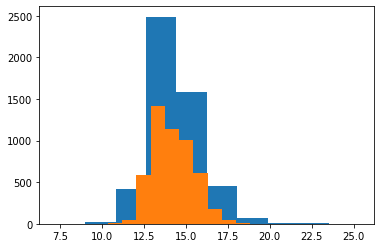

In [29]:
plt.hist(y_test)
plt.hist(pred)

## ULMFit

In [37]:
import pandas as pd
import numpy as np
from ast import literal_eval
from tqdm import tqdm_notebook
from collections import Counter
import re

#viz
import matplotlib.pyplot as plt
import seaborn as sns

from fastai.text import *
from fastai.callbacks import CSVLogger, SaveModelCallback

from pythainlp.ulmfit import *

model_path = 'models/'

In [39]:
tt = Tokenizer(tok_func = ThaiTokenizer, lang = 'th', pre_rules = pre_rules_th, post_rules=post_rules_th)
processor = [TokenizeProcessor(tokenizer=tt, chunksize=10000, mark_fields=False),
            NumericalizeProcessor(vocab=None, max_vocab=60000, min_freq=3)]

data_lm = (TextList.from_df(thaime, model_path, cols=['texts'], processor=processor)
    .random_split_by_pct(valid_pct = 0.01, seed = 1412)
    .label_for_lm()
    .databunch(bs=64))
data_lm.sanity_check()
data_lm.save('thaime_lm.pkl')

In [40]:
data_lm = load_data(model_path,'thaime_lm.pkl')
data_lm.sanity_check()
len(data_lm.train_ds), len(data_lm.valid_ds)

(33354, 336)

In [42]:
data_lm.show_batch(5)

idx,text
0,cbt for new normal ) xxbos พัฒนา ศักยภาพ แหล่งท่องเที่ยว และ เส้นทาง ท่องเที่ยว ทาง ประวัติศาสตร์ และ วัฒนธรรม xxbos โครงการ ส่งเสริม อุตสาหกรรม สร้างสรรค์ ทางวัฒนธรรม : ภาพยนตร์ และ xxunk xxbos โครง การผลิต ถ่าน xxunk ชา ร์ ผสม น้ำ หมัก ชีวภาพ จาก วัสดุ เหลือใช้ ทาง การเกษตร แบบ เคลื่อนที่ เพื่อ สร้าง นัก เทคโนโลยี เกษตร รุ่นใหม่ xxbos มาตรฐาน
1,บ้าน หนอง ตาก เนื้อ หมู่ ที่ 10 ตำบล ทุ่ง กระ บ่ำ xxbos 7. ปรับปรุง ภูมิทัศน์ บริเวณ คัน สระน้ำ บ้าน หนอง xxunk หมู่ ที่ 3 ตำบล หนอง ปลิง xxbos 3. ก่อสร้าง ถนน คอนกรีตเสริมเหล็ก สาย ทางเข้า โรง บรรจุ xxunk ชุมชน ดอน เสือ
2,เฒ่า ตำบล ลำปาว อำเภอ เมือง จังหวัด กาฬสินธุ์ xxbos โครง การซ่อมแซม ถนนลูกรัง บ้าน หนองสรวง หมู่ ที่ 2 สาย หนองสรวง - ไชย วาร รหัส สาย ทาง (กส.ถ 57 - xxunk ) ขนาด กว้าง 5 เมตร ยาว
3,หมู่ ที่ 20 / เทศบาลตำบล ยาง ตลาด อำเภอ ยาง ตลาด จังหวัด กาฬสินธุ์ xxbos ก่อสร้าง ถนน คอนกรีตเสริมเหล็ก สาย สร้าง ดง ไป ถึง แยก สำนักสงฆ์ xxbos ก่อสร้าง ถนน คอนกรีตเสริมเหล็ก เส้นทาง จาก หน้าบ้าน นาย ยง ยุทธ วรรณ บุบ ผา - บ้าน กุด xxunk xxbos โครงการ ขุดเจาะ บ่อ บาดาล น้ำ
4,10 บ้าน โพน นา ดี - บ้าน xxunk ) ตำบล หนอง ผือ อำเภอ เขา วง จัง ห xxunk xxunk สินธุ์ xxbos โครง การปรับปรุง ซ่อมแซม ถนน คอนกรีตเสริมเหล็ก ภายใน หมู่บ้าน หมู่ ที่ 4 บ้าน โพน นา ดี - หมู่ ที่ 1 บ้าน


In [44]:
config = dict(emb_sz=400, n_hid=1550, n_layers=4, pad_token=1, qrnn=False, tie_weights=True, out_bias=True,
             output_p=0.25, hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15)
trn_args = dict(drop_mult=0.9, clip=0.12, alpha=2, beta=1)

learn = language_model_learner(data_lm, AWD_LSTM, config=config, pretrained=False, **trn_args)

#load pretrained models
learn.load_pretrained(**_THWIKI_LSTM)

In [45]:
learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: 

In [ ]:
len(learn.data.vocab.itos)

In [ ]:
#train frozen
print('training frozen')
learn.freeze_to(-1)
learn.fit_one_cycle(1, 1e-3, moms=(0.8, 0.7))

In [ ]:

#train unfrozen
print('training unfrozen')
learn.unfreeze()
learn.fit_one_cycle(10, 1e-4, moms=(0.8, 0.7))